## Accessing IO Land Use/Land Cover data with the Planetary Computer STAC API

This dataset contains global estimates of 10-class land use/land cover for 2020, derived from ESA Sentinel-2 imagery at 10m resolution. In this notebook, we'll show how to access and work with this data through the Planetary Computer.

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.
The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.

More complete documentation is available on the [Planetary Computer data catalog](https://planetarycomputer.microsoft.com/dataset/io-lulc).

### Environment setup

In [1]:
from dask.distributed import Client as dask_client
from matplotlib.colors import ListedColormap
from pystac_client import Client
from pystac.extensions.label import LabelExtension as label
from pystac.extensions.raster import RasterExtension as raster
from pystac.extensions.projection import ProjectionExtension as proj
from shapely.geometry import shape
from shapely.ops import transform

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import planetary_computer as pc
import pyproj
import rasterio
import stackstac

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)

### Select a region and find data items

We'll pick an area surrounding Manila, Philippines and use the STAC API to find what data items are avaialable. We won't select a date range since this dataset contains items from a single timeframe in 2020.

In [2]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [120.88256835937499, 14.466596475463248],
            [121.34948730468749, 14.466596475463248],
            [121.34948730468749, 14.81737062015525],
            [120.88256835937499, 14.817370620155254],
            [120.88256835937499, 14.466596475463248],
        ]
    ],
}

In [3]:
# TODO: staging
catalog = Client.open("https://planetarycomputer-staging.microsoft.com/api/stac/v1")

search = catalog.search(collections=["io-lulc"], intersects=area_of_interest)

# Check how many items were returned, there could be more pages of results as well
items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 4 Items


We found 4 items that intersect with our AoI, which means the data we want to work with is spread out over 4 non-overlapping GeoTIFF files stored on blob storage. In order to merge them together, we could open each item, clip to the subset of our AoI, and merge them together manually with rasterio. We'd also have to reproject each item which may span multiple UTM projections. 

Instead, we'll use the [stackstac](https://stackstac.readthedocs.io/en/latest/) library to read, merge, and reproject in a single step - all without loading the rest of the file data we don't need.

In [4]:
# The STAC metadata contains some information we'll want to use when creating
# our merged dataset. Get the EPSG code of the first item and the nodata value.
item = next(search.get_items())
epsg = proj.ext(item).epsg
nodata = raster.ext(item.assets["data"]).bands[0].nodata
items = [pc.sign(item).to_dict() for item in search.get_items()]

# Create a single DataArray from out multiple resutls with the corresponding
# rasters projected to a single CRS. Note that we set the dtype to ubyte, which
# matches our data, since stackstac will use float64 by default.
stack = stackstac.stack(items, epsg=epsg, dtype=np.ubyte, fill_value=nodata)

stack

,Array,Chunk
Bytes,107.00 GiB,1.00 MiB
Shape,"(4, 1, 194711, 147510)","(1, 1, 1024, 1024)"
Count,138483 Tasks,110780 Chunks
Type,uint8,numpy.ndarray


Start up a local Dask cluster to allow us to do parallel reads. Use the following URL to open a dashboard in the Hub's Dask Extension. 

In [5]:
client = dask_client(processes=False)
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


### Mosaic and clip the raster

So far, we haven't read in any data. Stackstac has used the STAC metadata to construct a DataArray that will contain our Item data. Let's mosaic the rasters across the `time` dimension (remember, they're all from a single synthesized "time" from 2020) and drop the single `band` dimension. This is also a lazy operation and won't perform a read.

In [6]:
merged = stackstac.mosaic(stack, dim="time", axis=None).squeeze()
merged

<xarray.DataArray 'stackstac-ac73f5982c0978def04dbc72bd36c9d1' (y: 194711, x: 147510)>
dask.array<getitem, shape=(194711, 147510), dtype=uint8, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates:
    band               <U4 'data'
  * x                  (x) float64 -5.668e+05 -5.667e+05 ... 9.083e+05 9.083e+05
  * y                  (y) float64 2.735e+06 2.735e+06 ... 7.884e+05 7.884e+05
    label:type         <U6 'raster'
    label:classes      object {'name': '', 'classes': ['nodata', 'water', 'tr...
    label:description  <U4 'lulc'
    end_datetime       <U20 '2021-01-01T00:00:00Z'
    start_datetime     <U20 '2020-01-01T00:00:00Z'
    raster:bands       object {'nodata': 0, 'spatial_resolution': 10}
    epsg               int64 32651
Attributes:
    spec:        RasterSpec(epsg=32651, bounds=(-566750.0, 788360.0, 908350.0...
    crs:         epsg:32651
    transform:   | 10.00, 0.00,-566750.00|\n| 0.00,-10.00, 2735470.00|\n| 0.0...
    resolution:  10.0

Now the 4 Items are represented as a unified dataset, we can trim it down to the bounding box of our area of interest. We projected the dataset to the CRS of our first item, so we'll need to reproject our initial GeoJSON to the same, then get the bounds in the CRS that matches the data.

In [7]:
aoi_poly = shape(area_of_interest)
from_crs = pyproj.CRS("EPSG:4326")
to_crs = pyproj.CRS(f"EPSG:{epsg}")

project = pyproj.Transformer.from_crs(from_crs, to_crs, always_xy=True).transform
utm_poly = transform(project, aoi_poly)
minx, miny, maxx, maxy = utm_poly.bounds

We're finally ready to read some data. Select the bounds of our AoI from the dataset and read it in.

In [8]:
%%time
clipped = merged.sel(y=slice(maxy, miny), x=slice(minx, maxx)).load()

CPU times: user 3.73 s, sys: 318 ms, total: 4.05 s
Wall time: 3.36 s


Now a quick plot to check that we've got the data we want.

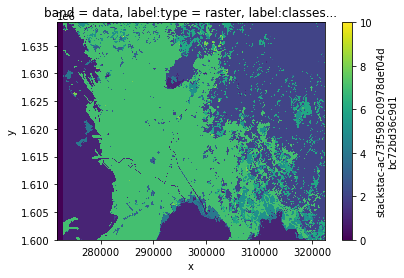

In [9]:
clipped.plot()
plt.show()

It looks good, but it doesn't look like a land cover map. The source GeoTIFFs contain a colormap and the STAC metadata contains the class names. We'll open one of the source files just to read this metadata and construct the right colors and names for our plot.

In [10]:
# TODO: sign item
class_names = label.ext(item).label_classes[0].classes
class_count = len(class_names)

with rasterio.open(item.assets["data"].href) as src:
    colormap_def = src.colormap(1)  # get metadata colormap for band 1
    colormap = [
        np.array(colormap_def[i]) / 255 for i in range(class_count)
    ]  # transform to matplot color format

cmap = ListedColormap(colormap)

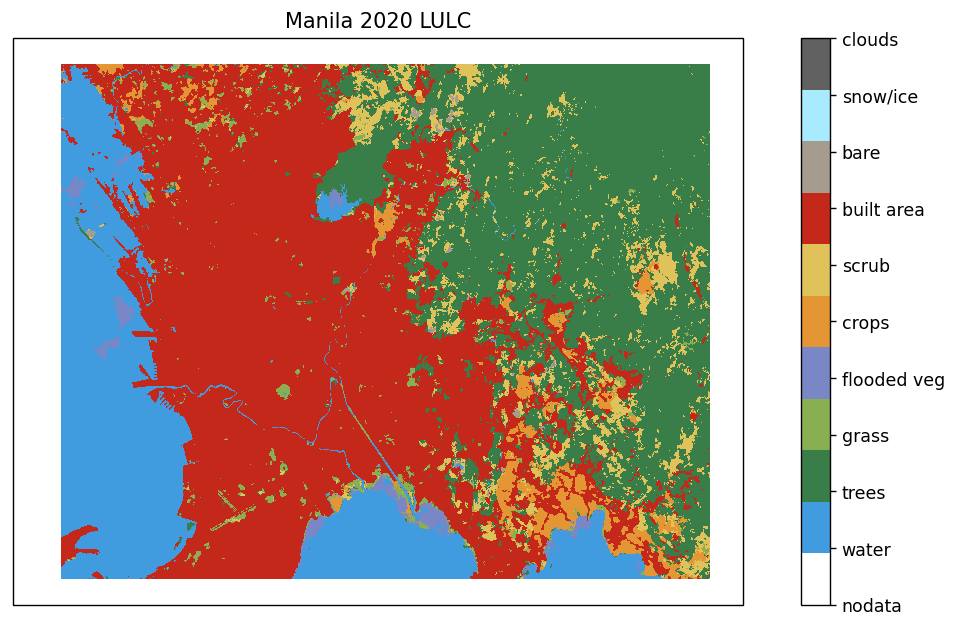

In [11]:
fig, ax = plt.subplots(
    figsize=(12, 6), dpi=125, subplot_kw=dict(projection=ccrs.epsg(epsg)), frameon=False
)
p = clipped.plot(ax=ax, transform=ccrs.epsg(epsg), cmap=cmap, add_colorbar=False)
ax.set_title("Manila 2020 LULC")

cbar = plt.colorbar(p)
cbar.set_ticks(range(class_count))
cbar.set_ticklabels(class_names)

That looks better. Let's also plot a histogram of the pixel values to see the distribution of land cover types within our area of interest. We can reuse the colormap we generated to help tie the two visualizations together.

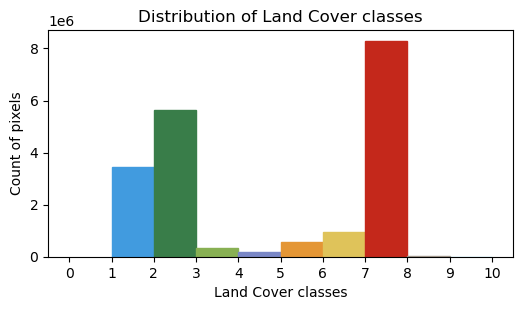

In [12]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=100)
_, _, patches = clipped.plot.hist(ax=ax)

plt.title("Distribution of Land Cover classes")
ax.xaxis.set_ticks(range(class_count))
plt.xlabel("Land Cover classes")
plt.ylabel("Count of pixels")

for i, rectangle in enumerate(patches):
    rectangle.set_color(colormap[i])